In [1]:
%load_ext autoreload
%autoreload 2

## Load the necessary packages

In [2]:
import sys
import os
import torch
import numpy as np

In [3]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))

## Start: Importing local packages. As I don't know how to run it as module
## with torchrun  (e.g., python -m trainer.Coronary_ddp_trainer)

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils.logger import Logging
from src.data.wave_dataset import generate_training_dataset, r, u
from src.nn.pde import wave_operator

DEVICE = "cpu"

In [8]:
NUMER_OF_POINTS = 200

# Parameters of equations
a = 0.5
c = 2

[ics_sampler, bcs_sampler, res_sampler] = generate_training_dataset(DEVICE)


dom_coords = torch.tensor([[0.0, 0.0], [1.0, 1.0]], dtype=torch.float32, device=DEVICE)
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], NUMER_OF_POINTS)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], NUMER_OF_POINTS)[:, None]
t_mesh, x_mesh = np.meshgrid(t, x)
X_star = torch.tensor(
    np.hstack((t_mesh.flatten()[:, None], x_mesh.flatten()[:, None])),
    dtype=torch.float32,
    device=DEVICE,
)

u_star = u(X_star, a, c)
f_star = r(X_star, a, c)


t, x = X_star[:, 0:1], X_star[:, 1:2]


TEST_CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, "testing_checkpoints/Wave")

logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

logger.print(f"Device used {DEVICE}")
logger.print(f"Result directory {model_dirname}")

INFO:src.utils.logger:Device used cpu
INFO:src.utils.logger:Result directory /home/ubuntu/afrah/code/pinn_learnable_activation/testing_checkpoints/Wave/2024-09-30_14-36-51-058207


In [17]:
TANH_NORM_DIST = "../../model/a2/wave_tanh_normal_a2.pth"
BSPLINE_DIST = "../../model/a1/wave_bspline_a1.pth"
CHEBTSHEV_DIST = "../../model/a1/wave_chebyshev_a1.pth"
GRBF_DIST = "../../model/a2/wave_grbf_a2.pth"
JACOBI_DIST = "../../model/a1/wave_jacobi_a1.pth"
TANH_PARAM_DIST = "../../model/a2/wave_tanh_trainable_a2.pth"
FOURIER_DIST = "../../model/a1/wave_fourier_a1.pth"


MODEL_PATH_LIST = {
    "tanh": TANH_NORM_DIST,
    "param_tanh": TANH_PARAM_DIST,
    "grbf": GRBF_DIST,
    "bspline": BSPLINE_DIST,
    "chebyshev": CHEBTSHEV_DIST,
    "jacobi": JACOBI_DIST,
    "fourier": FOURIER_DIST,
}


all_loss_history = {}

In [18]:
# Dictionary mapping solver names to their corresponding modules


all_loss_history = {}
SOLVER_TO_MODULE = {
    "KAN_GRBF": "src.nn.grbf",
    "jacobi": "src.nn.jacobi",
    "bspline": "src.nn.bspline",
    "chebyshev": "src.nn.chebyshev",
    "MLP": "src.nn.tanh_parameterized",
    "MLP2": "src.nn.tanh",
    "fourier": "src.nn.fourier",
}


for activation, model_path in MODEL_PATH_LIST.items():
    logger.print(f"MODEL_PATH {model_path}")
    # Load the state from the saved model
    state = torch.load(
        model_path,
    )
    config = state.get("config", {})
    solver = config.get("solver")

    # Extract model configuration from state
    model_activation_name = config.get("activation")
    model_architecture = config.get("network")
    loss_history = state.get("loss_history")
    # Dynamically import the correct module and class
    if solver in SOLVER_TO_MODULE:
        module = __import__(SOLVER_TO_MODULE[solver], fromlist=["PINNKAN"])
        PINNKAN = getattr(module, "PINNKAN")

        # Initialize fluid and solid models
        model = PINNKAN(model_architecture, model_activation_name).to(DEVICE)

    model.load_state_dict(state["model_state_dict"])
    logger.print(f"Model {activation} loaded from {model_path}")
    logger.print(f"activation:  , {config.get('activation')}")
    logger.print(f"solver:  , {config.get('solver')}")
    logger.print(f"problem:  , {config.get('problem')}")
    logger.print(f"number of iterations:  , {len(next(iter(loss_history.values())))}")
    logger.print(f"batch size:  , {config.get('batch_size')}")
    logger.print(f"network:  , {config.get('network')}")
    logger.print(f"term loss weights :  , {config.get('weights')}")
    all_loss_history[activation] = loss_history

    [u_pred, f_pred] = wave_operator(model, t, x)
    if u_pred.is_cuda:
        u_pred = u_pred.cpu()
        f_pred = f_pred.cpu()

    logger.print(
        f"Model {activation} with iterations: {len(loss_history[next(iter(loss_history))])}"
    )

    X_analytic = X_star.detach().numpy()
    u_analytic = u_star.detach().numpy()
    f_analytic = f_star.detach().numpy()
    u_pred = u_pred.detach().numpy()
    f_pred = f_pred.detach().numpy()

    error_u = (
        np.linalg.norm(u_analytic - u_pred, 2) / np.linalg.norm(u_analytic, 2) * 100.0
    )
    error_f = (
        np.linalg.norm(f_analytic - f_pred, 2)
        / np.linalg.norm(f_analytic + 1e-9, 2)
        * 100.0
    )

    logger.print("Relative L2 error_u: {:.2e}".format(error_u))
    logger.print("Relative L2 error_f: {:.2e}".format(error_f))

    for key in loss_history:
        logger.print("Final loss %s: %e" % (key, loss_history[key][-1]))

    logger.print("******************************\n")

logger.print("file directory:", logger.get_output_dir())

INFO:src.utils.logger:MODEL_PATH ../../model/a2/wave_tanh_normal_a2.pth


INFO:src.utils.logger:Model tanh loaded from ../../model/a2/wave_tanh_normal_a2.pth
INFO:src.utils.logger:activation:  , tanh2
INFO:src.utils.logger:solver:  , MLP2
INFO:src.utils.logger:problem:  , None
INFO:src.utils.logger:number of iterations:  , 60001
INFO:src.utils.logger:batch size:  , 128
INFO:src.utils.logger:network:  , [2, 300, 300, 300, 300, 1]
INFO:src.utils.logger:term loss weights :  , [100.0, 100.0, 1.0]
INFO:src.utils.logger:Model tanh with iterations: 60001
INFO:src.utils.logger:Relative L2 error_u: 1.36e+01
INFO:src.utils.logger:Relative L2 error_f: 2.63e+10
INFO:src.utils.logger:Final loss lbcs: 4.263114e-04
INFO:src.utils.logger:Final loss linitial: 7.793251e-05
INFO:src.utils.logger:Final loss lphy: 1.167435e-01
INFO:src.utils.logger:******************************

INFO:src.utils.logger:MODEL_PATH ../../model/a2/wave_tanh_trainable_a2.pth
INFO:src.utils.logger:Model param_tanh loaded from ../../model/a2/wave_tanh_trainable_a2.pth
INFO:src.utils.logger:activation: 

# Process the loss data

```py
all_loss_history = {
    model1: {
        loss1: [],
        loss2: [],
        ...
    },
    model2: {
        loss1: [],
        loss2: [],
        ...
    }, 
}

# example

all_loss_history = {
    tanh: {
        lbcs: [],
        phy: [],
        ...
    },
    fourier: {
        lbcs: [],
        phy: [],
        ...
    }, 
}
```


In [21]:
keys = all_loss_history.keys()
values = all_loss_history.values()

# Dictionary to store model and its summed loss
model_summed_loss_dict = {}

# Calculate summed loss
# Iterate over each model, e.g., tanh and sum their losses, e.g, lbcs, phy, ...
for model, loss_dict in zip(keys, values):
    total_loss = np.zeros(
        len(
            next(iter(loss_dict.values()))
        )  # Assume each loss history is of equal length
    )  # Initialize total_loss with zeros

    print(f"{model=}, #iter={len(total_loss)}")

    # Sum all losses across keys for each model
    # Exclude the physics loss for Helmholtz
    for key in loss_dict:
        if key not in ["lphy"]:
            total_loss += np.array(loss_dict[key])

    model_summed_loss_dict[model] = total_loss

# Determine the minimum length across all summed losses
min_length = min([len(x) for x in model_summed_loss_dict.values()])
# Truncate the lists in model_summed_loss_dict to the minimum length
for key in model_summed_loss_dict:
    model_summed_loss_dict[key] = model_summed_loss_dict[key][0:min_length]

print("Truncated model_summed_loss_dict:", model_summed_loss_dict.keys())
print("Truncated model_summed_loss_dict:", len(model_summed_loss_dict.get("tanh")))

model='tanh', #iter=60001
model='param_tanh', #iter=60001
model='grbf', #iter=60001
model='bspline', #iter=60001
model='chebyshev', #iter=60001
model='jacobi', #iter=60001
model='fourier', #iter=60001
Truncated model_summed_loss_dict: dict_keys(['tanh', 'param_tanh', 'grbf', 'bspline', 'chebyshev', 'jacobi', 'fourier'])
Truncated model_summed_loss_dict: 60001


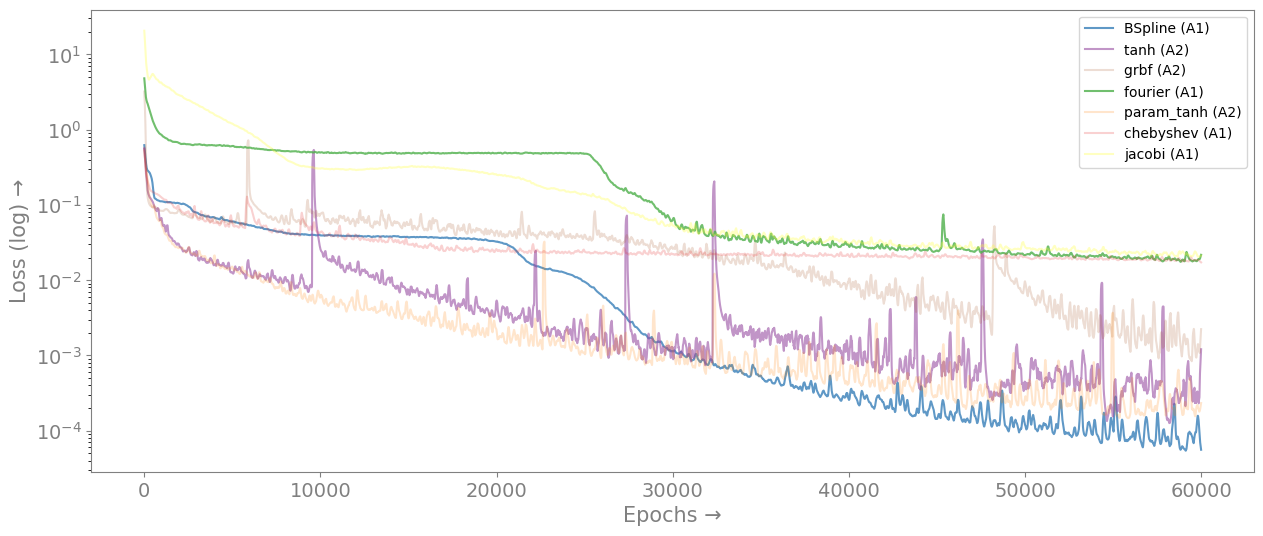

In [23]:
from matplotlib import pyplot as plt

from src.utils.plot_loss import plot_loss_history


fig, ax = plt.subplots()
fig.set_size_inches([15, 6])

plot_loss_history(
    model_summed_loss_dict["bspline"],
    ax,
    "#377eb8",
    name="BSpline (A1)",
    alpha=0.8,
    window=100,
    show_avg=False,
    show_lower=False,
)
plot_loss_history(
    model_summed_loss_dict["tanh"],
    ax,
    "#984ea3",
    name="tanh (A2)",
    alpha=0.6,
    window=100,
    show_avg=False,
    show_lower=False,
)
plot_loss_history(
    model_summed_loss_dict["grbf"],
    ax,
    "#a65628",
    name="grbf (A2)",
    alpha=0.2,
    window=100,
    show_avg=False,
    show_lower=False,
)
plot_loss_history(
    model_summed_loss_dict["fourier"],
    ax,
    "#4daf4a",
    name="fourier (A1)",
    alpha=0.8,
    window=100,
    show_avg=False,
    show_lower=False,
)
plot_loss_history(
    model_summed_loss_dict["param_tanh"],
    ax,
    "#ff7f00",
    name="param_tanh (A2)",
    alpha=0.2,
    window=100,
    show_avg=False,
    show_lower=False,
)
plot_loss_history(
    model_summed_loss_dict["chebyshev"],
    ax,
    "#e41a1c",
    name="chebyshev (A1)",
    alpha=0.2,
    window=100,
    show_avg=False,
    show_lower=False,
)
plot_loss_history(
    model_summed_loss_dict["jacobi"],
    ax,
    "#ffff33",
    name="jacobi (A1)",
    alpha=0.3,
    window=100,
    show_avg=False,
    show_lower=False,
)


plt.savefig(os.path.join(logger.get_output_dir(), "loss_history_wave.png"))
plt.show()
plt.close("all")